In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots, COLORMAPS
from collections import Counter
from matplotlib.lines import Line2D
from aging.organization.dataframes import load_male_long_df, load_female_long_df, DF_PATHS
from tqdm import tqdm

In [2]:
import sklearn.feature_selection as sfs
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, StratifiedKFold, LeaveOneOut, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
import random
from sklearn.metrics import accuracy_score

In [3]:
format_plots()
#format_pizza_plots()

In [4]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [5]:
# Log transform function
def log_transform(x):
    return np.log1p(x + 1e-3)

In [6]:
# Create pipeline
pipeline = Pipeline([
    ('log_transform', FunctionTransformer(log_transform)),
    #('scaler', StandardScaler()),
    ('pca', PCA(n_components=11)),
    #("fs", sfs.SelectKBest(sfs.f_classif, k=50)),
    #('svm', SVC(kernel='linear'),
    ('svm', SVC(kernel="rbf"),
    #('svm', SVC(kernel="sigmoid"),
    )
])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=50, random_state=42)
loo = LeaveOneOut()

In [7]:
cmm = COLORMAPS.ont_male
cmf = COLORMAPS.ont_female
m_df = load_male_long_df(average_weeks=False, merge_size=False, merge_ages=True, df_path=DF_PATHS.usage_male).groupby(['age','mouse']).mean()
f_df = load_female_long_df(average_weeks=False, merge_size=False, filter_female=True, merge_ages=True, df_path=DF_PATHS.usage_female).groupby(['age','mouse']).mean()
m_df['sex'] = 'm'
m_df.set_index('sex', inplace = True, append=True)
f_df['sex'] = 'f'
f_df.set_index('sex', inplace = True, append=True)

# Combine male and female data into a single DataFrame
combined_df = pd.concat([m_df, f_df])
#combined_df.set_index('sex', inplace=True, append=True)

In [8]:
# take only first sample from each week
df = combined_df.copy()
ages= df.index.get_level_values('age')
weeks = (ages * 7) // 14
df['binned_age'] = weeks

sample = df.groupby(['mouse','binned_age','sex']).mean().reset_index()
df = sample.copy()
df.rename(columns={'binned_age': 'age'}, inplace=True)
df.set_index(['age', 'mouse','sex'], inplace=True)

In [9]:
#number of iterations for shuffle
it=100

In [10]:
age2=[]
acc=[]
n=10
#n=16
for i in tqdm(range(it)):
    temp = df.groupby(level=['age', 'sex']).apply(lambda x: x.sample(n=n,replace=False, random_state=i)).reset_index(level=[0, 1],drop=True)
    for age,_df in enumerate(temp.groupby('age')):
        age2.append(_df[0])
        x = _df[1].to_numpy()
        y=_df[1].index.get_level_values('sex')
        acc.append(np.mean(cross_val_score(pipeline, x, y, cv=rkf, n_jobs=-1)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [17:48<00:00, 10.68s/it]


In [11]:
np.mean(acc)

0.835648

In [12]:
sh_ages=[]
sh_acc=[]

for i in tqdm(range(it)):
    temp = df.groupby(level=['age', 'sex']).apply(lambda x: x.sample(n=n,replace=False, random_state=i)).reset_index(level=[0, 1],drop=True)
    for age,_df in enumerate(temp.groupby('age')):
        sh_ages.append(_df[0])
        x = _df[1].to_numpy()
        y=_df[1].index.get_level_values('sex')
        y = y.to_series().sample(frac=1, random_state=i).values
        sh_acc.append(np.mean(cross_val_score(pipeline, x, y, cv=rkf, n_jobs=-1)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [19:03<00:00, 11.43s/it]


In [13]:
# create df for plotting
df_sh = pd.DataFrame()
df_sh['acc']=sh_acc
df_sh['ages'] = sh_ages

df = pd.DataFrame()
df['acc']=acc
df['ages'] = age2

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

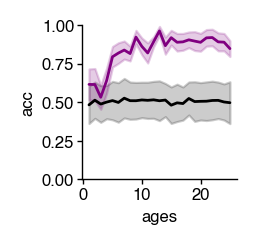

In [14]:
fig, ax = plt.subplots(figsize=(1, 1))
sns.lineplot(data=df_sh, x="ages", y="acc", ax=ax, color='black', estimator='mean', errorbar=('sd', 1))
sns.lineplot(data=df, x="ages", y="acc", ax=ax, color='purple', estimator='mean', errorbar=('sd', 1))
plt.ylim([0.0,1])
plt.legend([],[], frameon=False)
# Set custom x-ticks
#plt.xticks([2,5,10,15,20,25,30,35,])
sns.despine()

In [15]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ '07_28_fvm_sex_decoder_line.pdf', bbox_inches='tight')